In [1]:
# import packages for visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from map_plan import *

In [4]:
sample_map = create_sample_map()
obstacle_map = sample_map[:,:,0]
goal_map = sample_map[:,:,1]
current_pos_map = sample_map[:,:,2]

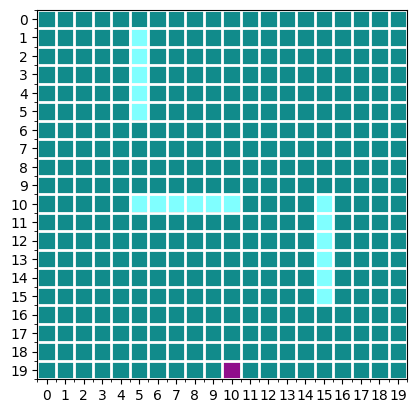

In [5]:
ax = plot_soft_position(obstacle_map, cmap='hot', alpha=0.9)
ax = plot_soft_position(goal_map, cmap='cool', alpha=0.5, ax=ax)

(tensor(0.), tensor(0.))
(tensor(0.2921), tensor(0.2921))


/Users/kyunghyuncho/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_1aidzjezue/croot/pytorch_1687856425340/work/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


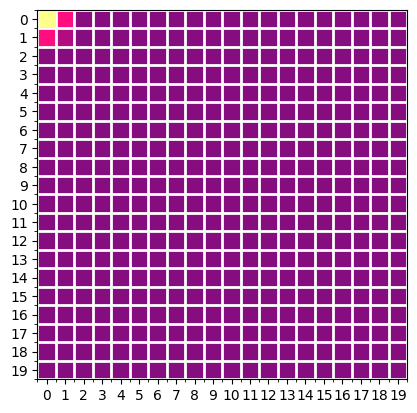

In [6]:
current_coord = get_hard_position(current_pos_map)
print(current_coord)
current_soft_map = get_soft_position(current_coord[0], current_coord[1])
current_soft_coord = get_hard_position(current_soft_map)
print(current_soft_coord)

ax = plot_soft_position(current_pos_map, cmap='spring', alpha=0.9)
ax = plot_soft_position(current_soft_map, cmap='hot', alpha=0.5, ax=ax)

(tensor(8.0000), tensor(8.))


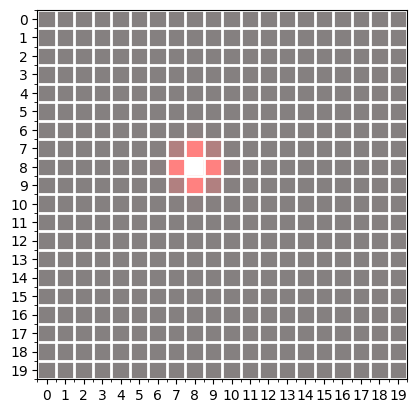

In [7]:
current_soft_map = get_soft_position(8, 8)
current_soft_coord = get_hard_position(current_soft_map)
print(current_soft_coord)

ax = plot_soft_position(current_soft_map, cmap='hot', alpha=0.5)

In [30]:
# perform gradient descent on the trajectory
# the beginning is the current position
trajectory_length = 20
trajectory = torch.zeros(trajectory_length, 2)
trajectory[0] = torch.tensor(get_hard_position(current_pos_map, argmax=True))

# randomly initialize the rest of the steps of `trajectory`
for i in range(1, trajectory_length):
    trajectory[i] = torch.tensor([np.random.randint(0, obstacle_map.shape[0]), 
                                  np.random.randint(0, obstacle_map.shape[0])])

n_steps = 1000
learning_rate = 0.1

for step in range(n_steps):
    trajectory = trajectory.clone().detach()
    trajectory.requires_grad = True
    trajectory.grad = None

    score = score_trajectory(trajectory, obstacle_map, goal_map, current_pos_map,
                             distance_coeff=10.0, 
                             collision_coeff=150.0, 
                             smoothness_coeff=10., 
                             distance_from_current_coeff=10.0)
    score.backward()

    trajectory = trajectory - learning_rate * trajectory.grad

    if step % 10 == 0:
        print(f'Step {step+1} Score {score.item()}')

trajectory = trajectory.detach()

Step 1 Score 1107.502197265625
Step 11 Score 582.9436645507812
Step 21 Score 429.65313720703125
Step 31 Score 372.1495361328125
Step 41 Score 262.6571350097656
Step 51 Score 201.76339721679688
Step 61 Score 195.96804809570312
Step 71 Score 179.3870849609375
Step 81 Score 119.35437774658203
Step 91 Score 99.14521026611328
Step 101 Score 100.05586242675781
Step 111 Score 100.29518127441406
Step 121 Score 98.23983764648438
Step 131 Score 97.5721435546875
Step 141 Score 98.10308837890625
Step 151 Score 97.17555236816406
Step 161 Score 96.0393295288086
Step 171 Score 94.89373016357422
Step 181 Score 92.6610336303711
Step 191 Score 84.98055267333984
Step 201 Score 84.64927673339844
Step 211 Score 84.46671295166016
Step 221 Score 84.3388900756836
Step 231 Score 84.24146270751953
Step 241 Score 84.15613555908203
Step 251 Score 84.07687377929688
Step 261 Score 83.99981689453125
Step 271 Score 83.9264907836914
Step 281 Score 83.8590087890625
Step 291 Score 83.79899597167969
Step 301 Score 83.746

In [31]:
# discretize the trajectory
trajectory = trajectory.round().long()

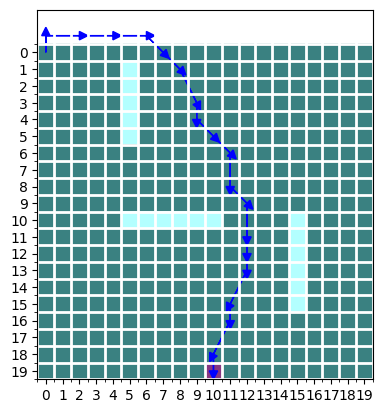

In [32]:
# plot the trajectory
ax = plot_soft_position(obstacle_map, cmap='hot', alpha=0.7)
ax = plot_soft_position(goal_map, cmap='cool', alpha=0.3, ax=ax)
for i in range(trajectory_length):
    if i > 0:
        # draw an arrow from the previous point to the current poin in the trajectory.
        ax.arrow(trajectory[i-1, 1], trajectory[i-1, 0], 
                 trajectory[i, 1]-trajectory[i-1, 1], 
                 trajectory[i, 0]-trajectory[i-1, 0], 
                 head_width=0.5, head_length=0.5, fc='b', ec='b')